# Paulo Vitor Correia de Oliveira - Lista 2

#### **Problema 1**

---

Um problema muito importante em estatística é a **regressão linear**, que consiste em ajustar uma reta a um conjunto de dados estatísticos. O método mais comum é o dos **mínimos quadrados**, mas também existem critérios alternativos que podem ser formulados como **problemas de programação linear**.

Dado um conjunto de pontos $(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)$, desejamos ajustar uma reta da forma:

$y = a_1x + a_0$

onde $a_1$ e $a_0$ são os parâmetros da regressão.

---

Vamos tomar primeiro as instruções dadas e obter coeficientes quaisquer $a_0, a_1$ e um conjunto de observações $(x_1,y_1), ..., (x_n, y_n)$.

In [1]:
import numpy as np
import pulp as pl
import matplotlib.pyplot as plt

Tomaremos observações e coeficientes aleatórios cuja seed pode ser determinada inicialmente a fins de reprodutibilidade.

In [2]:
np.random.seed(31415) # Seed = 5 dígitos de pi
N = 100 # Número de observações
G = 10 # Ordem de grandeza dos valores

# Coeficientes Reais
a0_ = np.random.uniform(low=-G,high=G)
a1_ = np.random.uniform(low=-G,high=G)

# Alternativa para Coeficientes
#a0_ = np.random.normal(loc=0,scale=G)
#a1_ = np.random.normal(loc=0,scale=G)

# Observações
x = np.linspace(-G,G,num=N)
eps = np.random.normal(loc=0,scale=a1_,size=N)
y = np.array([float(a0_+a1_*x[i]+eps[i]) for i in range(N)])

---

a) Formule um programa linear que minimize a soma dos desvios absolutos dos dados em relação à reta:

$$
\min_{a} \sum_{i=1}^n \big| y_i - (a_1x_i + a_0) \big|
$$

---

Modelamos o problema da seguinte forma:

In [3]:
p1 = pl.LpProblem("I",pl.LpMinimize)

# Variáveis
a0 = pl.LpVariable("a0")
a1 = pl.LpVariable("a1")

# Resíduos - Variáveis auxiliares
e = [pl.LpVariable(f"e{i}") for i in range(N)]

# Objetivo - Minimizar a soma dos resíduos
p1 += pl.lpSum(e)

# Restrição para caracterizar um resíduo linearmente
for i in range(N):
    p1 += (e[i] >= y[i]-(a0+a1*x[i]))
    p1 += (e[i] >= -(y[i]-(a0+a1*x[i])))
    
# Solução e Resposta
p1.solve(pl.PULP_CBC_CMD(msg=False))
print(f'Valores ótimos encontrados: a0 = {a0.varValue:.4f}, a1 = {a1.varValue:.4f}. Erro mínimo: {p1.objective.value():.4f}')

Valores ótimos encontrados: a0 = 3.2035, a1 = 3.6210. Erro mínimo: 249.7353


No código acima, primeiro criamos as variáveis principais que são os coeficientes $a_0$ e $a_1$. Além disso, nossa função objetivo deve minimizar a soma dos resíduos absolutos. Como não podemos usar módulo no pulp, definiremos os resíduos em um vetor de variáveis $e_i$ de modo que $e_i \geq max(y_i - (a_0+a_1 \cdot x_i))$, incorporando isso como restrições para cada $e_i$. Como todo $e_i$ será minimizado, o valor encontrado na solução ótima é $e_i = |y_i - (a_0+a_1 \cdot x_i)|$, tornando nossa função objetivo correta. 

Agora, vamos mostrar a reta encontradaem comparação com a real com um gráfico:

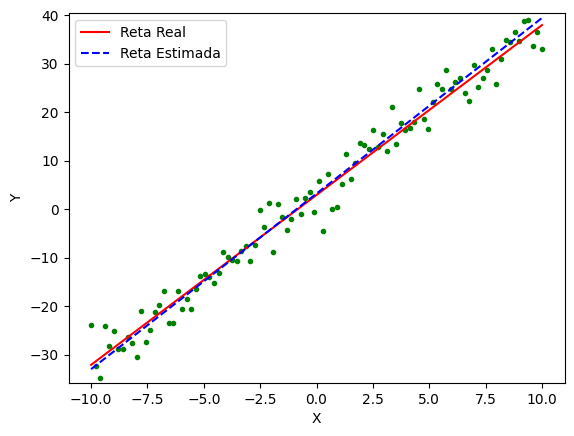

In [4]:
# Calcula o y estimado
y_est = np.array([a0.varValue + a1.varValue*x[i] for i in range(N)])
fig, ax = plt.subplots()

# Configurações do gráfico
plt.xlabel('X')
plt.ylabel('Y')
ax.set_xlim(x.min()-1, x.max()+1)
ax.set_ylim(min(y.min(),y_est.min())-1, max(y.max(),y_est.max())+1)

# Plotagem dos pontos e retas real e estimada
ax.plot(x,y,'.',c='green')
ax.plot(x,a0_+a1_*x,'-',c='red',label="Reta Real")
ax.plot(x,a0.varValue+a1.varValue*x,'--',c='blue',label="Reta Estimada")
ax.legend()
plt.show()

---

b) Formule um programa linear que minimize o maior desvio absoluto entre os pontos e a reta ajustada:

$$
\min_{a} \max_i \big| y_i - (a_1x_i + a_0) \big|
$$

---

Temos agora um problema de minimax. Faremos algo similar: Tomaremos um determinado z e minimizaremos ele sob a restrição dele assumir o valor máximo da expressão acima.

In [5]:
p2 = pl.LpProblem("II",pl.LpMinimize)

# Variáveis
a0 = pl.LpVariable("a0")
a1 = pl.LpVariable("a1")
z = pl.LpVariable("z")

# Objetivo - Minimizar z = max|yi - (a0+a1xi)|
p2 += (z)

# Restrição para caracterizar a forma de z
for i in range(N):
    p2 += (z >= y[i]-(a0+a1*x[i]))
    p2 += (z >= -(y[i]-(a0+a1*x[i])))
    
# Solução e Resposta
p2.solve(pl.PULP_CBC_CMD(msg=False))
print(f'Valores ótimos encontrados: a0 = {a0.varValue:.4f}, a1 = {a1.varValue:.4f}, minimax = {p2.objective.value():.4f}')

Valores ótimos encontrados: a0 = 2.0674, a1 = 3.3608, minimax = 7.7008


Novamente, faremos um gráfico para comparar os resultados:

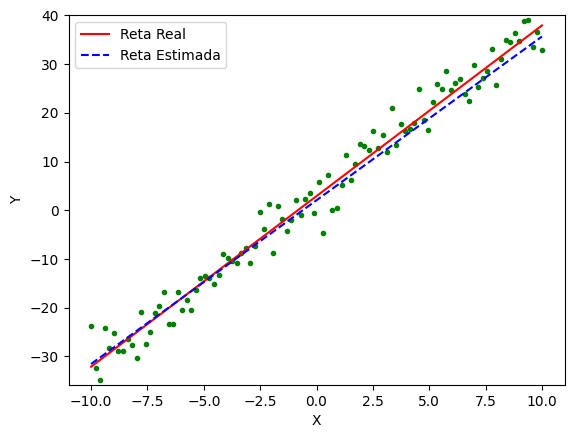

In [6]:
# Novamente, calculamos o y estimado
y_est = np.array([a0.varValue + a1.varValue*x[i] for i in range(N)])
fig, ax = plt.subplots()

# Configurações do gráfico
plt.xlabel('X')
plt.ylabel('Y')
ax.set_xlim(x.min()-1, x.max()+1)
ax.set_ylim(min(y.min(),y_est.min())-1, max(y.max(),y_est.max())+1)

# Plotagem dos pontos e retas real e estimada
ax.plot(x,y,'.',c='green')
ax.plot(x,a0_+a1_*x,'-',c='red',label="Reta Real")
ax.plot(x,a0.varValue+a1.varValue*x,'--',c='blue',label="Reta Estimada")
ax.legend()
plt.show()

---

c) Mostre como o modelo pode ser generalizado para ajustar polinômios em vez de retas:

$$
y = a_kx^k + a_{k-1}x^{k-1} + \ldots + a_1x + a_0
$$

---

Primeiro, modelaremos o polinômio: criamos k+1 variáveis representando os coeficientes e tomaremos os valores reais deles.

In [7]:
# Reconfiguração do problema
k = 5 # Grau do polinômio
N = 30; G = 3

# Função Polinomial
def poly(_x, _a):
    _a = np.asarray(_a) 
    return sum(_a[i] * (_x**i) for i in range(len(_a)))

x = np.linspace(-G,G,num=N)
eps = np.random.normal(loc=0,scale=25,size=N)
a_ = np.random.uniform(low=-G,high=G,size=k+1)
y = poly(x, a_) + eps

Agora, faremos o código que modela o problema equivalente ao a), apenas bastando fazer a substituição adequada para um polinômio.

In [8]:
p3 = pl.LpProblem("III-a",pl.LpMinimize)

# Variáveis
a = [pl.LpVariable(f"a{i}") for i in range(k+1)]

# Resíduos - Variáveis auxiliares
e = [pl.LpVariable(f"e{i}") for i in range(N)]

# Objetivo - minimizar a soma dos resíduos
p3 += pl.lpSum(e)

# Restrição para caracterizar um resíduo linearmente
for i in range(N):
    # Restrições usando polinômios
    p3 += (e[i] >= y[i]-pl.lpSum([a[j]*(x[i]**j) for j in range(k+1)]))
    p3 += (e[i] >= -(y[i]-pl.lpSum([a[j]*(x[i]**j) for j in range(k+1)])))
    
# Solução e Resposta
p3.solve(pl.PULP_CBC_CMD(msg=False))
print(f'Valores ótimos encontrados: a = {[aa.varValue for aa in a]}. Erro mínimo: {p3.objective.value():.4f}')

Valores ótimos encontrados: a = [-7.2655475, 4.6216798, 6.0149543, -8.1039131, 1.5800864, -1.6102379]. Erro mínimo: 508.2653


Veja que apenas trocamos uma soma manual por um lpsum de uma combinação de potências de $x_i$ e coeficientes. Mostrando nosso gráfico, temos:

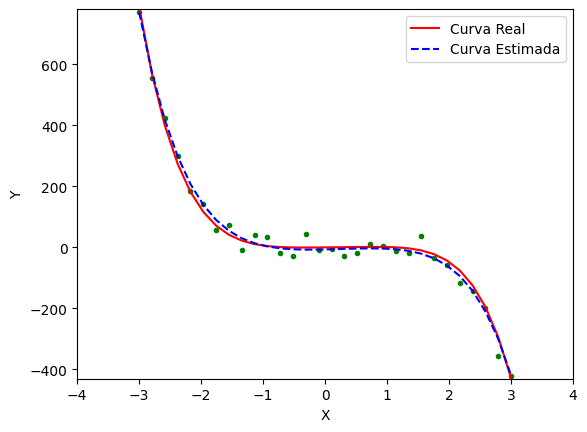

In [9]:
# Calcula o y estimado
afinal = np.array([a[j].varValue for j in range(k+1)])
y_est = np.array([poly(x[i],afinal) for i in range(N)])
fig, ax = plt.subplots()

# Configurações do gráfico
plt.xlabel('X')
plt.ylabel('Y')
ax.set_xlim(x.min()-1, x.max()+1)
ax.set_ylim(min(y.min(),y_est.min())-10, max(y.max(),y_est.max())+10)

# Plotagem dos pontos e curvas real e estimada
ax.plot(x,y,'.',c='green')
ax.plot(x,poly(x,a_),'-',c='red',label="Curva Real")
ax.plot(x,poly(x,afinal),'--',c='blue',label="Curva Estimada")
ax.legend()
plt.show()

Também faremos para o item b novamente, bastando modificar o nosso problema como fizemos antes:

In [10]:
p4 = pl.LpProblem("III-b",pl.LpMinimize)

# Variáveis
a = [pl.LpVariable(f"a{i}") for i in range(k+1)]

# Resíduos - Variáveis auxiliares
z = pl.LpVariable("z")

# Objetivo - minimizar a soma dos resíduos
p4 += (z)

# Restrição para caracterizar um resíduo linearmente
for i in range(N):
    # Restrições usando polinômios
    p4 += (z >= y[i]-pl.lpSum([a[j]*(x[i]**j) for j in range(k+1)]))
    p4 += (z >= -(y[i]-pl.lpSum([a[j]*(x[i]**j) for j in range(k+1)])))
    
# Solução e Resposta
p4.solve(pl.PULP_CBC_CMD(msg=False))
print(f'Valores ótimos encontrados: a = {[aa.varValue for aa in a]}. Objetivo: {p4.objective.value():.4f}')

Valores ótimos encontrados: a = [7.4324672, 8.2667408, 2.9709243, -5.2486507, 1.3181414, -1.9897303]. Objetivo: 38.1052


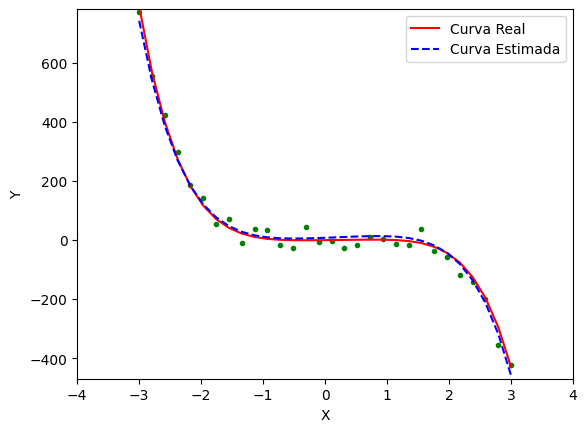

In [11]:
# Calcula o y estimado
afinal = np.array([a[j].varValue for j in range(k+1)])
y_est = np.array([poly(x[i],afinal) for i in range(N)])
fig, ax = plt.subplots()

# Configurações do gráfico
plt.xlabel('X')
plt.ylabel('Y')
ax.set_xlim(x.min()-1, x.max()+1)
ax.set_ylim(min(y.min(),y_est.min())-10, max(y.max(),y_est.max())+10)

# Plotagem dos pontos e curvas real e estimada
ax.plot(x,y,'.',c='green')
ax.plot(x,poly(x,a_),'-',c='red',label="Curva Real")
ax.plot(x,poly(x,afinal),'--',c='blue',label="Curva Estimada")
ax.legend()
plt.show()

---

d) Faça o mesmo procedimento usando dados em dimensão maior para resolver a regressão.

---

Faremos algo similar com o item a), para uma regressão linear em dimensão maior. Nesse exemplo, usaremos pontos no $\mathbb{R}^4$, isto é:

$$
\min_{a} \sum_{i=1}^n \big| y_i - (a_3x_3 + a_2x_2 + a_1x_i + a_0) \big|
$$

In [12]:
np.random.seed(31415) # Seed = 5 dígitos de pi
N = 100 # Número de observações
G = 5 # Ordem de grandeza dos valores
dim = 4 # Dimensão dos pontos da regressão linear

# Coeficientes Reais
a_ = np.random.uniform(low=-G,high=G,size=dim)

# Alternativa para Coeficientes
#a_ = np.random.normal(loc=0,scale=G,size=dim)

# Observações
x = np.linspace(-G,G,num=N)
eps = np.random.normal(loc=0,scale=0.5,size=N)
y = np.array([sum([a_[j] * x[i]**j for j in range(dim)]) for i in range(N)])
y = y + eps

Modelaremos o problema de forma análoga, apenas generalizando os conceitos para uma dimensão maior.

In [13]:
p5 = pl.LpProblem("V-a",pl.LpMinimize)

# Variáveis
a = [pl.LpVariable(f"a{i}") for i in range(dim)]

# Resíduos - Variáveis auxiliares
e = [pl.LpVariable(f"e{i}") for i in range(N)]

# Objetivo - Minimizar a soma dos resíduos
p5 += pl.lpSum(e)

# Restrição para caracterizar um resíduo linearmente
for i in range(N):
    p5 += (e[i] >= y[i]-pl.lpSum([a[j]*(x[i]**j) for j in range(dim)]))
    p5 += (e[i] >= -(y[i]-pl.lpSum([a[j]*(x[i]**j) for j in range(dim)])))
    
# Solução e Resposta
p5.solve(pl.PULP_CBC_CMD(msg=False))
print(f'Valores reais dos coeficientes: a = {[float(aa) for aa in a_]}')
print(f'Valores ótimos encontrados: a = {[aa.varValue for aa in a]}.\nErro mínimo: {p5.objective.value()}')

Valores reais dos coeficientes: a = [1.4581860590875468, 1.7517416985133494, 4.707039860486713, 3.848043643065953]
Valores ótimos encontrados: a = [1.5686621, 1.8166915, 4.6977727, 3.8454892].
Erro mínimo: 35.17917305719999


Pela alta dimensionalidade dos pontos, não é possível fazermos gráficos como no caso dos pontos no $\mathbb{R}^2$, mas veja que as nossas estimativas para os coeficientes continuam sendo bem próximas dos originais que geraram os pontos. Por fim, faremos a mesma coisa para minimizar o erro máximo:

$$
\min_{a} \max_{i} \big| y_i - (a_3x_3 + a_2x_2 + a_1x_i + a_0) \big|
$$

In [14]:
p5 = pl.LpProblem("V-b",pl.LpMinimize)

# Variáveis
a = [pl.LpVariable(f"a{i}") for i in range(dim)]

# Resíduos - Variáveis auxiliares
z = pl.LpVariable("z")

# Objetivo - Minimizar a soma dos resíduos
p5 += (z)

# Restrição para caracterizar um resíduo linearmente
for i in range(N):
    p5 += (z >= y[i]-pl.lpSum([a[j]*(x[i]**j) for j in range(dim)]))
    p5 += (z >= -(y[i]-pl.lpSum([a[j]*(x[i]**j) for j in range(dim)])))
    
# Solução e Resposta
p5.solve(pl.PULP_CBC_CMD(msg=False))
print(f'Valores reais dos coeficientes: a = {[float(aa) for aa in a_]}')
print(f'Valores ótimos encontrados: a = {[aa.varValue for aa in a]}.\nErro minmax: {p5.objective.value()}')

Valores reais dos coeficientes: a = [1.4581860590875468, 1.7517416985133494, 4.707039860486713, 3.848043643065953]
Valores ótimos encontrados: a = [1.2503152, 1.7724411, 4.7317176, 3.8464457].
Erro minmax: 1.0221813


Nesse caso, veja que ainda há uma boa aproximação, mas o coeficiente $a_0$ divergiu um pouco mais.

#### **Problema 2**

---

**(Problema 1 - Capítulo 9)**

Uma empresa de exploração de petróleo precisa selecionar 5 de 10 locais possíveis para perfuração $S_1,...,S_{10}$, minimizando o custo total dado que os custos são dados por $C_1,...,C_{10}$. Existem várias restrições geográficas e de desenvolvimento que limitam quais locais podem ser explorados simultaneamente.

 A avaliação dos locais $S_1$ e $S_7$ o impedirá de explorar o local $S_8$.
- A avaliação do local $S_3$ ou $S_4$ o impede de avaliar o local $S_5$.
- Do grupo $S_5, S_6, S_7, S_8$, apenas dois locais podem ser avaliados.

Formule um programa inteiro para determinar o esquema de exploração de custo mínimo que satisfaça essas restrições.



---

Vamos definir as seguintes variáveis de decisão:

- $x_i=1$ se o local $S_i$ for selecionado e 0 caso contrário para $i=1...10$

E com elas, queremos:

- Minimizar $x_1 \cdot C_1 + ... + x_{10} \cdot C_{10}$

Sob:

- $x_1 + ... + x_{10} = 5$
- $x_1 + x_7 + x_{10} \leq 2$
- $x_3 + x_5 \leq 1$
- $x_4 + x_5 \leq 1$

Além disso, a regra final diz "only two sites ...", mas isso pode ser interpretado tanto como uma igualdade quanto uma desigualdade (apenas dois = não mais que dois ou apenas dois = necessariamente dois). De qualquer forma, é certo que temos:

- $x_5 + x_6 + x_7 + x_8 \leq 2$

No caso da igualdade, basta adicionarmos (a critério de interpretação):

- $x_5 + x_6 + x_7 + x_8 \geq 2$

Agora, vamos implementar isso em Python. Primeiro, vamos escolher os coeficientes $C_i$:

In [15]:
C = [1, 1, 2, 3, 5, 8, 13, 21, 35, 56] # Exemplo escolhido
# C = np.random.uniform(low=0,high=15,size=10)

Agora, criamos o modelo.

In [16]:
p5 = pl.LpProblem("V",pl.LpMinimize)

# Variáveis
x = [pl.LpVariable(f'x{i}',cat="Binary") for i in range(1,11)]

# Objetivo - Minimizar a combinação linear das escolhas.
p5 += pl.lpSum([x[j]*C[j] for j in range(10)])

# Restrições
p5 += (pl.lpSum(x) == 5)
p5 += (x[0] + x[6] + x[9] <= 2)
p5 += (x[2] + x[4] <= 1)
p5 += (x[3] + x[4] <= 1)
p5 += (x[4] + x[5] + x[6] + x[7] <= 2)
# Se for correto interpretar como igualdade, descomente abaixo
# p5 += (x[4] + x[5] + x[6] + x[7] >= 2)
    
# Solução e Resposta
p5.solve(pl.PULP_CBC_CMD(msg=False))
print(f'Valores ótimos encontrados: x = {[xx.varValue for xx in x]}. Objetivo: {p5.objective.value():.4f}')

Valores ótimos encontrados: x = [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]. Objetivo: 15.0000


#### **Problema 3**

---

**(Problema 2 - Capítulo 9)**

Uma empresa deseja montar um "pacote" acadêmico para um programa de treinamento executivo. Existem cinco faculdades na região, cada uma oferecendo cursos nas seis áreas que o programa foi projetado para abordar. 

- O pacote deve consistir de 10 cursos, e cada uma das seis áreas deve ser coberta. 

A anuidade (taxa básica), cobrada quando pelo menos um curso é feito, na faculdade $i$ é $T_i$ (independente do número de cursos realizados). Além disso, cada faculdade impõe uma taxa adicional para cada curso ($C_{ij}$), sendo a taxa dependente da faculdade e da área de instrução.

Formule um programa inteiro para determinar o valor mínimo que a empresa deve gastar para atender aos requisitos do programa.

---

Primeiro, vamos definir os valores de $T_i$ e $C_{ij}$:

In [17]:
T = [1, 9, 3, 7, 5]
C = [
    [1, 2, 3, 4, 5, 6], # 1 até 6
    [3, 1, 4, 1, 5, 9], # Dígitos de pi
    [1, 6, 1, 8, 0.3, 3], # Dígitos de phi
    [2, 7, 1, 8, 2, 8], # Dígitos de e
    [1, 4, 1, 4, 2, 1] # Dígitos de sqrt(2)
]
#np.random.seed(31415)
#T = np.random.uniform(low=0,high=20,size=5)
#C = np.random.uniform(low=0,high=20,size=30).reshape(5,6)

Agora, modelaremos o problema. Primeiro, seja $\{x_{ij} : i \in [1,5], j \in [1,6]\}$ variáveis binárias representando se um curso de área $j$ foi adquirido na universidade e $y_i$ representando se algum curso foi adquirido na universidade $i$.

Nossa função objetivo é dada por:

- Minimizar $\sum_{i=1}^{5} \left(\sum_{j=1}^{6} C_{ij} \cdot x_{ij}\right) + \sum_{i=1}^{5}{T_i \cdot y_i}$

Sob as condições de todas as áreas serem cobertas e escolhermos 10 cursos no total, além da compatibilidade entre x e y:

- $\sum_{i=1}^{5} \sum_{j=1}^{6} x_{ij} = 10$
- $\sum_{i=1}^{5} x_{ij} \geq 1 \quad \forall j \in [1,6]$
- $\sum_{j=1}^{6} x_{ij} \leq 6 \cdot y_i \quad \forall i \in [1,5]$
- $\sum_{j=1}^{6} x_{ij} \geq y_i \quad \forall i \in [1,5]$

Veja que as duas condições finais são necessárias pois tanto não queremos que $y_i$ seja escolhido sem nenhum $x_{ij}$ ser escolhido quanto o contrário também não deve ocorrer.

Implementando o código, temos:

In [18]:
p6 = pl.LpProblem("VI",pl.LpMinimize)

# Variáveis
x = [[pl.LpVariable(f'x{i}{j}',cat="Binary") for j in range(1,7)] for i in range(1,6)]
y = [pl.LpVariable(f'y{i}',cat="Binary") for i in range(1,6)]

# Objetivo - Minimizar a combinação linear das escolhas.
p6 += (pl.lpSum([y[i]*T[i] for i in range(5)]) + pl.lpSum([C[i//6][i%6]*x[i//6][i%6] for i in range(30)]))

# Restrições
p6 += (pl.lpSum([x[i//6][i%6] for i in range(30)]) == 10)
for j in range(6):  
    p6 += (pl.lpSum([x[i][j]] for i in range(5)) >= 1)
for i in range(5):
    p6 += (pl.lpSum([x[i][j]] for j in range(6)) <= 6*y[i])
    p6 += (pl.lpSum([x[i][j]] for j in range(6)) >= y[i])

# Solução e Resposta
p6.solve(pl.PULP_CBC_CMD(msg=False))
print(f'Valores ótimos encontrados: \n x = {[[xxx.varValue for xxx in xx] for xx in x]}. \n y = {[yy.varValue for yy in y]} \n Objetivo: {p6.objective.value():.4f}')

Valores ótimos encontrados: 
 x = [[1.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 1.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 1.0, 0.0, 1.0, 1.0]]. 
 y = [1.0, 0.0, 1.0, 0.0, 1.0] 
 Objetivo: 23.3000


#### **Problema 4**

---

**(Problema 2 - Capítulo 8)**

Em um dia específico da temporada turística, uma empresa de aluguel de carros deve fornecer veículos para quatro destinos, de acordo com a seguinte programação:

| Destino | Carros necessários |
|---------|--------------------|
| A       | 2                  |
| B       | 3                  |
| C       | 5                  |
| D       | 7                  |

A empresa possui três filiais das quais os carros podem ser fornecidos. No dia em questão, o inventário de cada uma das filiais era o seguinte:

| Filial | Carros disponíveis |
|--------|--------------------|
| 1      | 6                  |
| 2      | 1                  |
| 3      | 10                 |

E as distâncias entre filiais e destinos são dadas abaixo:

|   | A | B | C | D |
|---|----|----|----|----|
| Filial 1 | 7  | 11 | 3  | 2  |
| Filial 2 | 1  | 6  | 0  | 1  |
| Filial 3 | 9  | 15 | 8  | 5  |

Formule um programa inteiro para determinar o esquema de exploração de custo mínimo (proporcional à milhas percorridas) que satisfaça essas restrições.

---

Primeiro, vamos ter que determinar as variáveis que expressaremos nosso custo mínimo. Veja que se decidirmos quantos carros enviaremos para cada destino em cada filial, já teremos como definido o nosso cenário. Com isso, considere $x_{ij}$ como o número de carros enviados da filial ${i}$ ao $j°$ destino (A = 1°, B = 2°, C = 3°, D = 4°) e seja $c_{ij}$ o custo de fazer o trajeto $i \rightarrow j$.

Com isso, nossa função objetivo é minimizar $\sum_{i=1}^{3} \sum_{j=1}^{4} x_{ij} \cdot c_{ij}$, sob as restrições de:

- $\sum_{j=1}^{4} x_{ij} \leq q_{i} \quad \forall i \in [1,3]$

Onde $q_1 = 6, q_2 = 1, q_3 = 10$.

- $\sum_{i=1}^{3} x_{ij} = o_{j} \quad \forall j \in [1,4]$

Sendo $o_1 = 2, o_2 = 3, o_3 = 5, o_4 = 7$.

Veja que a nossa função de minimização está minimizando as milhas percorridas, que são proporcionais ao custo, então a resposta ótima no nosso modelo é a resposta ótima no cenário geral.

Agora, vamos definir $C_{ij}$, $q_i$ e $o_j$ no nosso código e depois prosseguir com o modelo do problema. 

In [19]:
# Custos de translado
c = [
    [7,11,3,2],
    [1,6,0,1],
    [9,15,8,5]
]

# Limites de carros por filial
q = [6,1,10]

# Objetivo de carros usados por destino
o = [2,3,5,7]

In [20]:
p7 = pl.LpProblem("VII",pl.LpMinimize)

# Variáveis
x = [[pl.LpVariable(f'x{i}{j}',lowBound=0,cat="Integer") for j in range(1,5)] for i in range(1,4)]

# Objetivo
p7 += (pl.lpSum([x[i//4][i%4]*c[i//4][i%4] for i in range(12)]))

# Restrições
for i in range(3):
    p7 += (pl.lpSum([x[i][j] for j in range(4)]) <= q[i])
for j in range(4):
    p7 += (pl.lpSum([x[i][j] for i in range(3)]) == o[j])

# Solução e Resposta
p7.solve(pl.PULP_CBC_CMD(msg=False))
print(f'Valores ótimos encontrados: \n x = {[[xxx.varValue for xxx in xx] for xx in x]}.\nObjetivo: {p7.objective.value():.4f}')

Valores ótimos encontrados: 
 x = [[0.0, 1.0, 5.0, 0.0], [0.0, 1.0, 0.0, 0.0], [2.0, 1.0, 0.0, 7.0]].
Objetivo: 100.0000


#### **Problema 5**

---

**(Problema 4 - Capítulo 8)**

Uma grande rede de varejo de artigos esportivos deseja comprar 300, 200, 150, 500 e 400 raquetes de tênis de cinco tipos diferentes. Quatro fabricantes foram contatados e fornecerão no máximo as seguintes quantidades (todos os cinco tipos de raquetes combinados):

| Fabricante | Número de raquetes |
|------------|--------------------|
| $M_1$      | 600                |
| $M_2$      | 500                |
| $M_3$      | 300                |
| $M_4$      | 400                |

A loja estima que seu lucro por raquete varia de acordo com o fabricante, conforme a tabela abaixo:

|       | $R_1$ | $R_2$ | $R_3$ | $R_4$ | $R_5$ |
|-------|-------|-------|-------|-------|-------|
| $M_1$ | 5.50  | 7.00  | 8.50  | 4.50  | 3.00  |
| $M_2$ | 6.00  | 6.50  | 9.00  | 3.50  | 2.00  |
| $M_3$ | 5.00  | 7.00  | 9.50  | 4.00  | 2.50  |
| $M_4$ | 6.50  | 5.50  | 8.00  | 5.00  | 3.50  |

Como os pedidos devem ser feitos para maximizar o lucro?

---

Vamos definir nossa matriz de lucros, nossa lista de demandas e nossa lista de limites dos fabricantes como vemos abaixo:

In [21]:
# Limites de fabricante
m = [600, 500, 300, 400]

# Demandas
d = [300, 200, 150, 500, 400]

# Matriz de lucro
c = [
    [5.5, 6, 5, 6.5],
    [7, 6.5, 7, 5.5],
    [8.5, 9, 9.5, 8],
    [4.5, 3.5, 4, 5],
    [3, 2, 2.5, 3.5]    
]

Assim como no problema anterior, encontrar as variáveis é bastante direto: se decidirmos quantas raquetes serão pedidas de cada fabricante, definiremos já todo nosso problema. Então, seja $x_{ij}$ o número de raquetes do tipo $i$ pedidas do fabricante $j$.

Veja que nossa função objetivo pode ser descrita como:

- Maximizar $\sum_{i=1}^{5} \sum_{j=1}^{4} c_{ij} \cdot x_{ij}$

Sob as restrições dos fornecedores (que não podem ser ultrapassadas) e nossas demandas (que devem ser supridas e não ultrapassadas).

- $\sum_{i=1}^{5} x_{ij} \leq m_j \quad \forall j \in [1,4]$

- $\sum_{j=1}^{4} x_{ij} = d_i \quad \forall i \in [1,5]$

Modelando isso como um problema linear, temos:

In [22]:
p8 = pl.LpProblem("VIII",pl.LpMinimize)

# Variáveis
x = [[pl.LpVariable(f'x{i}{j}',lowBound=0,cat="Integer") for j in range(1,5)] for i in range(1,6)]

# Objetivo
p8 += (pl.lpSum([x[i//4][i%4]*c[i//4][i%4] for i in range(20)]))

# Restrições
for i in range(5):
    p8 += (pl.lpSum([x[i][j] for j in range(4)]) == d[i])
for j in range(4):
    p8 += (pl.lpSum([x[i][j] for i in range(5)]) <= m[j])

# Solução e Resposta
p8.solve(pl.PULP_CBC_CMD(msg=False))
print(f'Valores ótimos encontrados: \n x = {[[xxx.varValue for xxx in xx] for xx in x]}.\nLucro: {p8.objective.value():.4f}')

Valores ótimos encontrados: 
 x = [[300.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 200.0], [0.0, 0.0, 0.0, 150.0], [0.0, 500.0, 0.0, 0.0], [100.0, 0.0, 300.0, 0.0]].
Lucro: 6750.0000


#### **Problema Extra**

---

**(Problema 69 - Capítulo 420)**



---